In [303]:
from src import data_handler
from src import visualization

%load_ext autoreload
%autoreload

In [ ]:
PATH_CONFIG = 'data/config/transportation.json'
map = data_handler.Map(PATH_CONFIG)
visualization.draw_map(map)

---

In [ ]:
coords = '''
'''

coords_out = coords.replace('\n', '\n},\n')
coords_out = coords_out.replace(', ', ',\n')
coords_out = coords_out.replace('45.', '{\n\t"lat": 45.')
coords_out = coords_out.replace('18.', '\t"lon": 18.') + '\n}'

print(coords_out)

---
### Test

In [306]:
import requests
import numpy as np
import plotly.graph_objects as go
import time
from scipy.spatial import Voronoi
import pandas as pd
import shapely
from shapely.ops import unary_union

link_template = "https://api.opentopodata.org/v1/aster30m?locations={}"

In [197]:
# # Heidelberg
# area = {
#     'top_left' : {
#         "lat" : 49.45314108607197,
#         "lon" :  8.598836023463372
#     },
#     'bottom_right' : {
#         "lat" : 49.35674378792299,
#         "lon" : 8.791660077089931
#     },
#     'n_points_lat' : 20,
#     'n_points_lon' : 40
# }

In [200]:
# Zagreb
area = {
    'top_left' : {
        "lat" : 45.88290804839089,
        "lon" : 15.779222787436899
    },
    'bottom_right' : {
        "lat" : 45.748117841442884,
        "lon" : 16.131947831759277
    },
    'n_points_lat' : 20,
    'n_points_lon' : 40
}

In [198]:
# # Osijek
# area = {
#     'top_left' : {
#         "lat" : 45.582192556138516,
#         "lon" : 18.63453482614465
#     },
#     'bottom_right' : {
#         "lat" : 45.52679570361777,
#         "lon" : 18.767093938381354
#     },
#     'n_points_lat' : 20,
#     'n_points_lon' : 40
# }

In [233]:
lon_linspace = np.linspace(area['top_left']['lon'], area['bottom_right']['lon'], area['n_points_lon'])
lat_linspace = np.linspace(area['top_left']['lat'], area['bottom_right']['lat'], area['n_points_lat'])
lon_mesh, lat_mesh = np.meshgrid(lon_linspace, lat_linspace)
lon_mesh[::2] +=  (lon_linspace[1] - lon_linspace[0])*0.5

lon = lon_mesh.flatten()
lat = lat_mesh.flatten()

lon_batches = lon.reshape(-1, 100)
lat_batches = lat.reshape(-1, 100)

In [234]:
altitude_container = {
    'lon' : [],
    'lat' : [],
    'altitude' : []
}

for lon, lat in zip(lon_batches, lat_batches):

    lon_lat = ' | '.join([ '{},{}'.format(llat, llon) for llon, llat in zip(lon, lat)])
    link = link_template.format(lon_lat)
    link_content = requests.get(link).json()

    for p in link_content['results']:

        altitude_container['lat'].append(p['location']['lat'])
        altitude_container['lon'].append(p['location']['lng'])
        altitude_container['altitude'].append(p['elevation'])       

    time.sleep(1)
 

In [260]:
fig = go.Figure()

fig.add_trace(
    go.Scattermapbox(
        lat = altitude_container['lat'],
        lon = altitude_container['lon'],
        # mode='markers',
        marker = {
            'size': 10,
            'color': altitude_container['altitude'],
            # 'opacity': 0.5
            'showscale':True
        },
        hoverinfo= 'lat+lon+text',
        # hoverlabel = dict(namelength = -1),
        text = [str(a) for a in altitude_container['altitude']]
        # name =' | '.join(name.split('_'))
    )
)

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiYmVuamFtaW5tZXNpYyIsImEiOiJja3ZucDRjcDQwdG1nMzNxZnJ6cHd2ZzNzIn0.uWSETefP3q7BrtrZ7B1a-g',
        center=go.layout.mapbox.Center(
            # lat = 45.55854878748722,
            # lon = 18.684848674241845
            # lat = 49.39899696293843,
            # lon = 8.67195560600178,
            lat = 45.809043592257105,
            lon = 15.95778297342564
        ),
        style='open-street-map',
        pitch=0,
        zoom=12, 
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    showlegend = False,
    width=1000,
    height=1000        
)

In [367]:
df = pd.DataFrame(altitude_container)

In [387]:
altitude_min = 200
altitude_max = 1000

mask = (df['altitude'] >= altitude_min) & (df['altitude'] <= altitude_max )

In [388]:
vor = Voronoi(df[['lat', 'lon']].to_numpy())

In [397]:
df

,lon,lat,altitude
0,15.783745,45.882908,190.0
1,15.792789,45.882908,149.0
2,15.801833,45.882908,130.0
3,15.810878,45.882908,121.0
4,15.819922,45.882908,121.0
...,...,...,...
795,16.095771,45.748118,102.0
796,16.104815,45.748118,97.0
797,16.113859,45.748118,92.0
798,16.122904,45.748118,101.0


In [396]:
vor.points

array([[45.88290805, 15.7837449 ],
       [45.88290805, 15.79278914],
       [45.88290805, 15.80183337],
       ...,
       [45.74811784, 16.11385937],
       [45.74811784, 16.1229036 ],
       [45.74811784, 16.13194783]])

In [400]:
regions[0]

[118, 115, 114, 117]

array([[45.84533111, 15.7837449 ],
       [45.84034272, 15.7759192 ],
       [45.85453116, 15.7759192 ],
       [45.84954277, 15.7837449 ]])

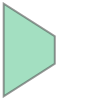

In [402]:
data_handler.convert_coords_to_shapely_polygon({ 'lat': vor.vertices[regions[0]][:,0], 'lon': vor.vertices[regions[0]][:,1]})

In [390]:
regions = [vor.regions[1:][i] for i in df[mask].index.values]
regions = [list(filter(lambda x: x != -1, r)) for r in regions]
# regions = [r for r in regions if len(r)>3]

In [392]:
stacked_polygons = unary_union([data_handler.convert_coords_to_shapely_polygon({ 'lat': vor.vertices[r][:,0], 'lon': vor.vertices[r][:,1]}) 
                               for r in regions])

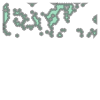

In [393]:
stacked_polygons

In [405]:
vor.points[0]

array([45.88290805, 15.7837449 ])

In [407]:
fig = go.Figure()

fig.add_trace(
    go.Scattermapbox(
        lat = df[mask]['lat'],
        lon = df[mask]['lon'],
        # mode='markers',
        marker = {
            'size': 10,
            'color': df[mask]['altitude'],
            # 'opacity': 0.5
            'showscale':True
        },
        hoverinfo= 'lat+lon+text',
        # hoverlabel = dict(namelength = -1),
        text = [str(a) for a in df[mask]['altitude']]
        # name =' | '.join(name.split('_'))
    )
)

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiYmVuamFtaW5tZXNpYyIsImEiOiJja3ZucDRjcDQwdG1nMzNxZnJ6cHd2ZzNzIn0.uWSETefP3q7BrtrZ7B1a-g',
        center=go.layout.mapbox.Center(
            # lat = 45.55854878748722,
            # lon = 18.684848674241845
            # lat = 49.39899696293843,
            # lon = 8.67195560600178,
            lat = 45.809043592257105,
            lon = 15.95778297342564
        ),
        style='open-street-map',
        pitch=0,
        zoom=12, 
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    showlegend = False,
    width=1000,
    height=1000        
)

fig.update_layout(
    mapbox = {
        'layers': [
            {
                'source': stacked_polygons.__geo_interface__,
                'type': 'fill',
                'color': 'blue',
                'opacity': 0.4
            } 
        ],
    },       
)